# Introduction
This tutorial shows how a H2O [Deep Learning](http://en.wikipedia.org/wiki/Deep_learning) model can be used to do supervised classification and regression. This tutorial covers usage of H2O from Python. An R version of this tutorial will be available as well in a separate document. This file is available in plain R, R markdown, regular markdown, plain Python and iPython Notebook formats, and the plots are available as PDF files. All documents are available [on Github](.). More examples and explanations can be found in our [H2O Deep Learning booklet](http://h2o.ai/resources/) and on our [H2O Github Repository](http://github.com/h2oai/h2o-3/).

### H2O Python Module

Load the H2O Python module.

In [15]:
import h2o

### Start H2O
Start up a 1-node H2O cloud on your local machine, and allow it to use all CPU cores and up to 2GB of memory:

In [17]:
h2o.init(max_mem_size_GB = 2)            #uses all cores by default
h2o.remove_all()                          #clean slate, in case cluster was already running

/Users/arno/anaconda/lib/python2.7/site-packages/h2o/connection.py:82: DeprecationWarning: `max_mem_size_GB` is deprecated. Use `max_mem_size` instead.
  warnings.warn("`max_mem_size_GB` is deprecated. Use `max_mem_size` instead.", category=DeprecationWarning)


H2O cluster uptime:,16 seconds 489 milliseconds
H2O cluster version:,3.9.1.99999
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster total free memory:,10.35 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None


To learn more about the h2o package itself, we can use Python's builtin help() function.

In [18]:
help(h2o)

Help on package h2o:

NAME
    h2o

FILE
    /Users/arno/anaconda/lib/python2.7/site-packages/h2o/__init__.py

DESCRIPTION
    # encoding: utf-8
    # module h2o
    # from (h2o)

PACKAGE CONTENTS
    assembly
    astfun
    connection
    cross_validation
    demo
    display
    estimators (package)
    expr
    frame
    grid (package)
    group_by
    h2o
    h2o_logging
    h2o_model_builder
    job
    model (package)
    transforms (package)
    two_dim_table
    utils (package)

SUBMODULES
    __init__

FUNCTIONS
    frame(frame_id, exclude='')
        Retrieve metadata for an id that points to a Frame.
        
        Parameters
        ----------
        frame_id : str
          A pointer to a Frame in H2O.
        
        Returns
        -------
          Python dict containing the frame meta-information

DATA
    __all__ = ['assembly', 'astfun', 'connection', 'cross_validation', 'de...
    __version__ = '3.9.1.99999'

VERSION
    3.9.1.99999




help() can be used on H2O functions and models. Jupyter's builtin shift-tab functionality also works

In [19]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
help(H2ODeepLearningEstimator)
help(h2o.import_file)

Help on class H2ODeepLearningEstimator in module h2o.estimators.deeplearning:

class H2ODeepLearningEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Method resolution order:
 |      H2ODeepLearningEstimator
 |      h2o.estimators.estimator_base.H2OEstimator
 |      h2o.model.model_base.ModelBase
 |      future.types.newobject.newobject
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_id=None, overwrite_with_best_model=None, checkpoint=None, pretrained_autoencoder=None, use_all_factor_levels=None, standardize=None, activation=None, hidden=None, epochs=None, train_samples_per_iteration=None, seed=None, adaptive_rate=None, rho=None, epsilon=None, rate=None, rate_annealing=None, rate_decay=None, momentum_start=None, momentum_ramp=None, momentum_stable=None, nesterov_accelerated_gradient=None, input_dropout_ratio=None, hidden_dropout_ratios=None, l1=None, l2=None, max_w2=None, initial_weight_distribution=None, initial_weight_scale=None, loss=N

##H2O Deep Learning
While H2O Deep Learning has many parameters, it was designed to be just as easy to use as the other supervised training methods in H2O. Early stopping, automatic data standardization and handling of categorical variables and missing values and adaptive learning rates (per weight) reduce the amount of parameters the user has to specify. Often, it's just the number and sizes of hidden layers, the number of epochs and the activation function and maybe some regularization techniques. 


### Let's have some fun first: Decision Boundaries
We start with a small dataset representing red and black dots on a plane, arranged in the shape of two nested spirals. Then we task H2O's machine learning methods to separate the red and black dots, i.e., recognize each spiral as such by assigning each point in the plane to one of the two spirals.

We visualize the nature of H2O Deep Learning (DL), H2O's tree methods (GBM/DRF) and H2O's generalized linear modeling (GLM) by plotting the decision boundary between the red and black spirals:

Let's get our imports first.

In [20]:
%matplotlib inline                         
#IMPORT ALL THE THINGS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

First, we need to upload our datasets to the the H2O cluster. The data is imported into H2OFrames, which operate similarly in function to pandas DataFrames.  

In this case, the cluster is running on our laptops. Data files are imported by their relative locations to this notebook.

In [21]:
import os
spiral = h2o.import_file(path = os.path.realpath("../data/spiral.csv"))
grid  = h2o.import_file(path = os.path.realpath("../data/grid.csv"))


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


Spiral is a simple data set consisting of two spirals of black and red dots.  
Grid is a 201 by 201 matrix with dimensions [-1.5, 1.5] by [-1.5, 1.5].

To visualize these datasets, we can pull them from H2OFrames into pandas DataFrames for easier plotting.

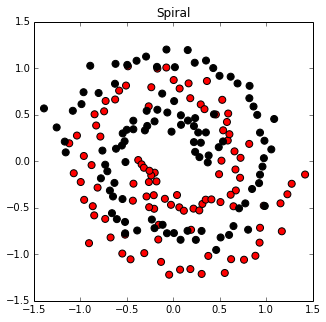

In [22]:
spiral_df = spiral.as_data_frame(use_pandas=True)
grid_df = grid.as_data_frame(use_pandas=True)
grid_x, grid_y = grid_df.x.reshape(201,201), grid_df.y.reshape(201,201)
spiral_r = spiral_df[spiral_df.color == "Red"]
spiral_k = spiral_df[spiral_df.color == "Black"]

spiral_xr, spiral_yr = spiral_r[spiral_r.columns[0]], spiral_r[spiral_r.columns[1]]
spiral_xk, spiral_yk = spiral_k[spiral_k.columns[0]], spiral_k[spiral_k.columns[1]]
    
markersize_ = 7**2
plt.figure(figsize = (5,5))
plt.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
plt.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title("Spiral");

###Model Construction
H2O in Python is designed to be very similar in look and feel to to scikit-learn. Models are initialized individually with desired or default parameters and then trained on data.  

Note that the below examples use model.train(), as opposed the traditional model.fit()
This is because h2o-py takes the data frame AND column indices for the feature and response columns, while scikit-learn takes in feature frames.

H2O supports model.fit() so that it can be incorporated into a scikit-learn pipeline, but we advise using train() in all other cases.

In [23]:
X = spiral.col_names[0:2]
y = spiral.col_names[2]
dl_model = H2ODeepLearningEstimator(epochs=1000)
dl_model.train(X, y, spiral)

gbm_model = H2OGradientBoostingEstimator()
gbm_model.train(X, y, spiral)

drf_model = H2ORandomForestEstimator()
drf_model.train(X, y, spiral)

glm_model = H2OGeneralizedLinearEstimator(family="binomial")
glm_model.fit(spiral[X], spiral[y])                                #model.fit() example

models = [dl_model, gbm_model, drf_model, glm_model]
m_names = ["Deep Learning", "Gradient Boosted Method", "Distributed Random Forest", "Generalized Linear Model"]



deeplearning Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%


/Users/arno/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: UserWarning: 

	`fit` is not recommended outside of the sklearn framework. Use `train` instead.


Now that we've trained four models to classify points as red or black based on their (x,y) coordinates.  
To see how our models have performed, we ask them to predict the colors of the grid.

Since we'll be doing a lot of spiral plotting, let's write a little helper function to keep things clean.

In [24]:
def plot_spirals(models, model_names):
    fig, ax = plt.subplots(2,2, figsize=(12,12))
    for k, subplot in enumerate(ax.flatten()):
        subplot.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
        subplot.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
        subplot.axis([-1.5, 1.5, -1.5, 1.5])
        subplot.set_title(model_names[k])
        subplot.set_xlabel('x')
        subplot.set_ylabel('y')
        pred_z = models[k].predict(grid).as_data_frame(True)
        subplot.contour(grid_x, grid_y, (pred_z['predict'] == 'Black').astype(np.int).reshape(201,201), colors='b')

Below are four graphs of the contour plots of the predictions, so that we can see how exactly the algorithms grouped the points into black and red.


deeplearning prediction Progress: [##################################################] 100%

gbm prediction Progress: [##################################################] 100%

drf prediction Progress: [##################################################] 100%

glm prediction Progress: [##################################################] 100%


/Users/arno/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


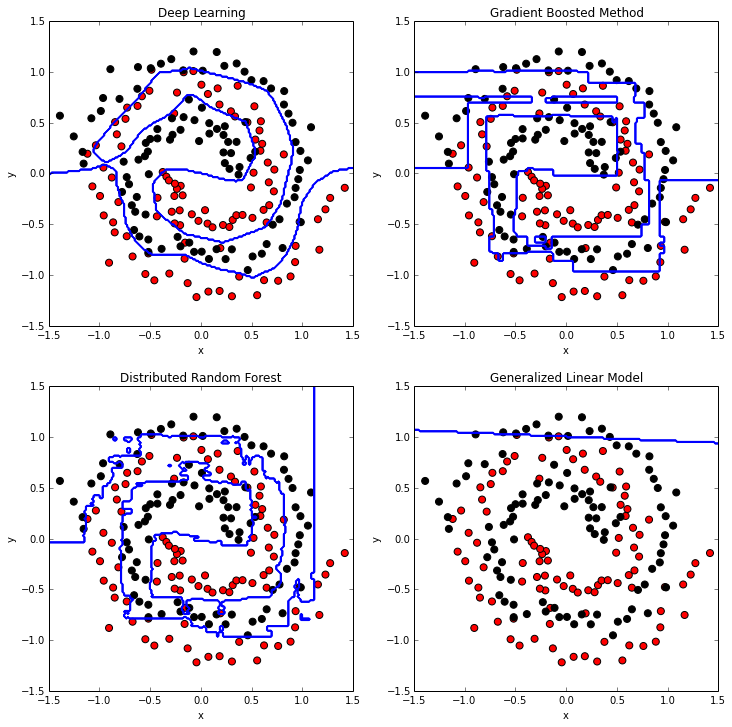

In [25]:
plot_spirals(models, m_names)

###A Deeper Dive into Deep Learning

Now let's explore the evolution of our deep learning model over training time (number of passes over the data, aka epochs).  
We will use checkpointing to ensure that we continue training the same model

In [26]:
dl_1 = H2ODeepLearningEstimator(epochs=1)
dl_1.train(X, y, spiral)

dl_250 = H2ODeepLearningEstimator(checkpoint=dl_1, epochs=250)
dl_250.train(X, y, spiral)

dl_500 = H2ODeepLearningEstimator(checkpoint=dl_250, epochs=500)
dl_500.train(X, y, spiral)

dl_750 = H2ODeepLearningEstimator(checkpoint=dl_500, epochs=750)
dl_750.train(X, y, spiral)


deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1457130434698_214

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.6 KB, 219 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0042857,0.0027407,0.0,0.0008165,0.0995545,0.4808506,0.0120858
,3,200,Rectifier,0.0,0.0,0.0,0.0228890,0.0523426,0.0,-0.0012119,0.0697734,0.9966968,0.0045200
,4,2,Softmax,,0.0,0.0,0.0022485,0.0042233,0.0,0.0012501,0.3832805,0.0000007,0.0008784




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.388936209654
R^2: -0.555744838615
LogLoss: 2.58489354436
AUC: 0.65415
Gini: 0.3083

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0257966685291: 


,Black,Red,Error,Rate
Black,15.0,85.0,0.85,(85.0/100.0)
Red,3.0,97.0,0.03,(3.0/100.0)
Total,18.0,182.0,0.44,(88.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0257967,0.6879433,171.0
max f2,0.0119929,0.8460237,180.0
max f0point5,0.9978453,0.6617647,83.0
max accuracy,0.9978453,0.66,83.0
max precision,1.0000000,1.0,0.0
max recall,0.0119929,1.0,180.0
max specificity,1.0000000,1.0,0.0
max absolute_MCC,0.9978453,0.3205776,83.0
max min_per_class_accuracy,0.9954692,0.66,89.0



Gains/Lift Table: Avg response rate: 50.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,1.0000000,2.0,2.0,1.0,1.0,0.02,0.02,100.0,100.0
,2,0.02,1.0000000,2.0,2.0,1.0,1.0,0.02,0.04,100.0,100.0
,3,0.03,0.9999999,2.0,2.0,1.0,1.0,0.02,0.06,100.0,100.0
,4,0.04,0.9999999,2.0,2.0,1.0,1.0,0.02,0.08,100.0,100.0
,5,0.05,0.9999998,2.0,2.0,1.0,1.0,0.02,0.1,100.0,100.0
,6,0.1,0.9999989,1.4,1.7,0.7,0.85,0.07,0.17,40.0,70.0
,7,0.15,0.9999970,0.2,1.2,0.1,0.6,0.01,0.18,-80.0,20.0
,8,0.2,0.9999923,0.8,1.1,0.4,0.55,0.04,0.22,-20.0,10.0
,9,0.3,0.9999247,1.6,1.2666667,0.8,0.6333333,0.16,0.38,60.0,26.6666667
,10,0.4,0.9994558,1.5,1.325,0.75,0.6625,0.15,0.53,50.0,32.5




Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_MSE,training_r2,training_logloss,training_AUC,training_lift,training_classification_error
,2016-03-04 14:27:57,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2016-03-04 14:27:57,0.064 sec,1500 rows/sec,0.09,1,18.0,0.4999721,-0.9998885,6.3364655,0.652,2.0,0.445
,2016-03-04 14:27:57,0.178 sec,2027 rows/sec,1.095,11,219.0,0.3889362,-0.5557448,2.5848935,0.65415,2.0,0.44



deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1457130434698_217

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.6 KB, 50,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0024967,0.0017561,0.0,0.0157245,0.1969066,0.0423196,0.2267263
,3,200,Rectifier,0.0,0.0,0.0,0.2587925,0.2424439,0.0,-0.0563759,0.2074049,0.5662112,0.7042034
,4,2,Softmax,,0.0,0.0,0.0051505,0.0037995,0.0,0.0012609,0.3426678,-0.0013987,0.0134808




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.213503453494
R^2: 0.145986186026
LogLoss: 0.710653025844
AUC: 0.8567
Gini: 0.7134

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.886916190341: 


,Black,Red,Error,Rate
Black,80.0,20.0,0.2,(20.0/100.0)
Red,23.0,77.0,0.23,(23.0/100.0)
Total,103.0,97.0,0.215,(43.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8869162,0.7817259,96.0
max f2,0.1551796,0.8960573,157.0
max f0point5,0.9115788,0.7944915,92.0
max accuracy,0.9115788,0.785,92.0
max precision,0.9999998,1.0,0.0
max recall,0.1551796,1.0,157.0
max specificity,0.9999998,1.0,0.0
max absolute_MCC,0.9115788,0.5714017,92.0
max min_per_class_accuracy,0.8869162,0.77,96.0



Gains/Lift Table: Avg response rate: 50.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9999991,2.0,2.0,1.0,1.0,0.02,0.02,100.0,100.0
,2,0.02,0.9999984,2.0,2.0,1.0,1.0,0.02,0.04,100.0,100.0
,3,0.03,0.9999975,2.0,2.0,1.0,1.0,0.02,0.06,100.0,100.0
,4,0.04,0.9999933,2.0,2.0,1.0,1.0,0.02,0.08,100.0,100.0
,5,0.05,0.9999824,2.0,2.0,1.0,1.0,0.02,0.1,100.0,100.0
,6,0.1,0.9986433,2.0,2.0,1.0,1.0,0.1,0.2,100.0,100.0
,7,0.15,0.9968906,1.8,1.9333333,0.9,0.9666667,0.09,0.29,80.0,93.3333333
,8,0.2,0.9950897,1.6,1.85,0.8,0.925,0.08,0.37,60.0,85.0
,9,0.3,0.9783629,1.6,1.7666667,0.8,0.8833333,0.16,0.53,60.0,76.6666667
,10,0.4,0.9602475,1.3,1.65,0.65,0.825,0.13,0.66,30.0,65.0




Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_MSE,training_r2,training_logloss,training_AUC,training_lift,training_classification_error
,2016-03-04 14:27:57,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2016-03-04 14:27:58,0.563 sec,3802 rows/sec,10.0,1,2000.0,0.2820990,-0.1283960,0.8298979,0.653,2.0,0.45
,2016-03-04 14:28:03,5.476 sec,9206 rows/sec,250.0,25,50000.0,0.2135035,0.1459862,0.7106530,0.8567,2.0,0.215



deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1457130434698_220

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.6 KB, 100,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0023218,0.0021014,0.0,0.0109697,0.2300993,0.0487408,0.2414762
,3,200,Rectifier,0.0,0.0,0.0,0.2307707,0.2510822,0.0,-0.0545706,0.1949384,0.6902981,0.4774137
,4,2,Softmax,,0.0,0.0,0.0063975,0.0065536,0.0,0.0013398,0.3858309,0.0000648,0.0301587




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.0725879211542
R^2: 0.709648315383
LogLoss: 0.226757885148
AUC: 0.9807
Gini: 0.9614

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.871006821364: 


,Black,Red,Error,Rate
Black,96.0,4.0,0.04,(4.0/100.0)
Red,10.0,90.0,0.1,(10.0/100.0)
Total,106.0,94.0,0.07,(14.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.8710068,0.9278351,85.0
max f2,0.5117019,0.9514563,106.0
max f0point5,0.9236588,0.9513274,79.0
max accuracy,0.8710068,0.93,85.0
max precision,1.0000000,1.0,0.0
max recall,0.2070472,1.0,122.0
max specificity,1.0000000,1.0,0.0
max absolute_MCC,0.8710068,0.8615522,85.0
max min_per_class_accuracy,0.7992176,0.91,91.0



Gains/Lift Table: Avg response rate: 50.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,1.0000000,2.0,2.0,1.0,1.0,0.02,0.02,100.0,100.0
,2,0.02,1.0000000,2.0,2.0,1.0,1.0,0.02,0.04,100.0,100.0
,3,0.03,1.0000000,2.0,2.0,1.0,1.0,0.02,0.06,100.0,100.0
,4,0.04,0.9999999,2.0,2.0,1.0,1.0,0.02,0.08,100.0,100.0
,5,0.05,0.9999999,2.0,2.0,1.0,1.0,0.02,0.1,100.0,100.0
,6,0.1,0.9999935,2.0,2.0,1.0,1.0,0.1,0.2,100.0,100.0
,7,0.15,0.9999501,2.0,2.0,1.0,1.0,0.1,0.3,100.0,100.0
,8,0.2,0.9997970,2.0,2.0,1.0,1.0,0.1,0.4,100.0,100.0
,9,0.3,0.9964903,2.0,2.0,1.0,1.0,0.2,0.6,100.0,100.0
,10,0.4,0.9659961,1.9,1.975,0.95,0.9875,0.19,0.79,90.0,97.5




Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_MSE,training_r2,training_logloss,training_AUC,training_lift,training_classification_error
,2016-03-04 14:28:03,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2016-03-04 14:28:03,0.511 sec,4024 rows/sec,10.0,1,2000.0,0.3103043,-0.2412172,0.9970685,0.6533,2.0,0.45
,2016-03-04 14:28:08,5.537 sec,9428 rows/sec,260.0,26,52000.0,0.1582083,0.3671667,0.5014118,0.8992,2.0,0.185
,2016-03-04 14:28:11,8.213 sec,12221 rows/sec,500.0,50,100000.0,0.0725879,0.7096483,0.2267579,0.9807,2.0,0.07



deeplearning Model Build Progress: [##################################################] 100%


You can see how the network learns the structure of the spirals with enough training time. 


deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%


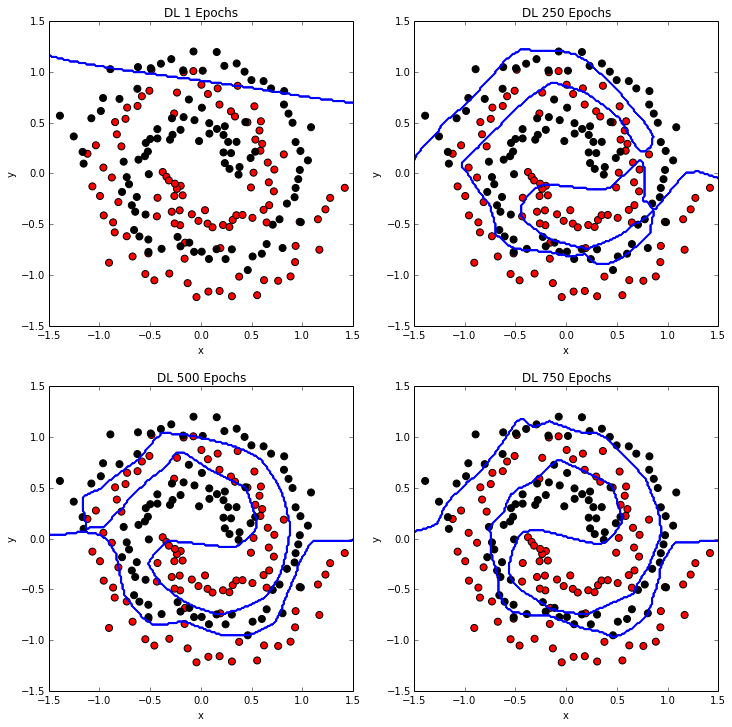

In [27]:
models_dl = [dl_1, dl_250, dl_500, dl_750]
m_names_dl = ["DL " + str(int(model.get_params()['epochs']['actual_value'])) + \
                                     " Epochs" for model in models_dl]

plot_spirals(models_dl, m_names_dl)

###Deep Learning Network Architecture
Of course, there is far more to constructing Deep Learning models than simply having them run longer.  
Consider the four following setups.

1. Single layer, 1000 nodes
2. Two layers, 200 nodes each
3. Three layers, 42 nodes each
4. Four layers, 11 -> 13 -> 17 -> 19

The H2O Architecture uses the hidden keyword to control model network architecture.  
Hidden takes a list of integers, representing the number of nodes in each layer.

In [28]:
dl_1 = H2ODeepLearningEstimator(hidden=[1000], epochs=500)
dl_1.train(X, y, spiral)

dl_2 = H2ODeepLearningEstimator(hidden=[200,200], epochs=500)
dl_2.train(X, y, spiral)

dl_3 = H2ODeepLearningEstimator(hidden=[42,42,42], epochs=500)
dl_3.train(X, y, spiral)

dl_4 = H2ODeepLearningEstimator(hidden=[11,13,17,19], epochs = 1000)
dl_4.train(X, y, spiral)


deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%


It is clear that different configurations can achieve similar performance, and that tuning will be required for optimal performance.


deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%


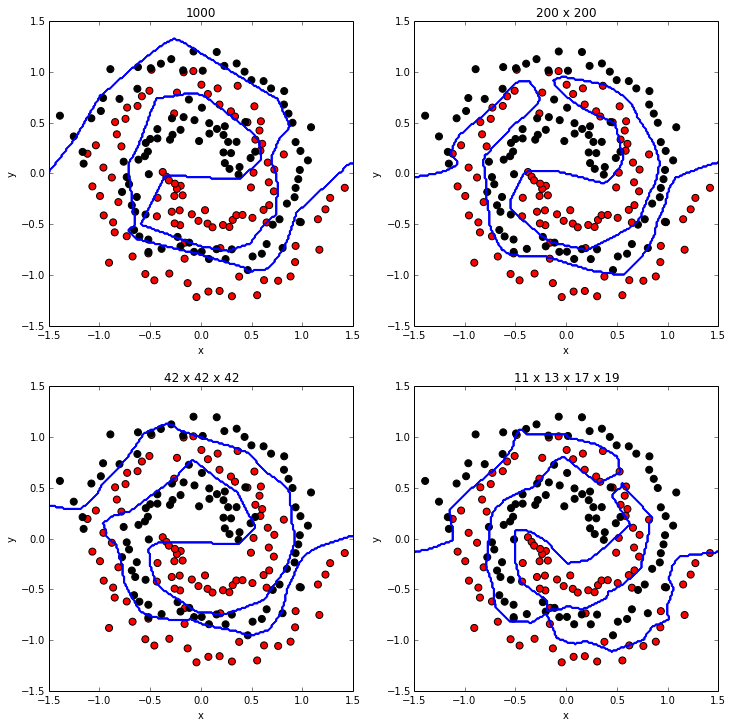

In [29]:
models_network = [dl_1, dl_2, dl_3, dl_4]
m_names_network = ["1000", "200 x 200", "42 x 42 x 42", "11 x 13 x 17 x 19"]

plot_spirals(models_network, m_names_network)

###Activation Functions
Next, we compare between different activation functions, including one with 50% dropout regularization in the hidden layers:

In [30]:
models_act = []
m_names_act = []
for i,method in enumerate(["Tanh","Maxout","Rectifier","RectifierWithDropout"]):
    models_act.append(H2ODeepLearningEstimator(activation=method, hidden=[100,100], epochs=1000))
    models_act[i].train(X, y, spiral)
    m_names_act.append("DL "+ method + " Activation")


deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%



deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%

deeplearning prediction Progress: [##################################################] 100%


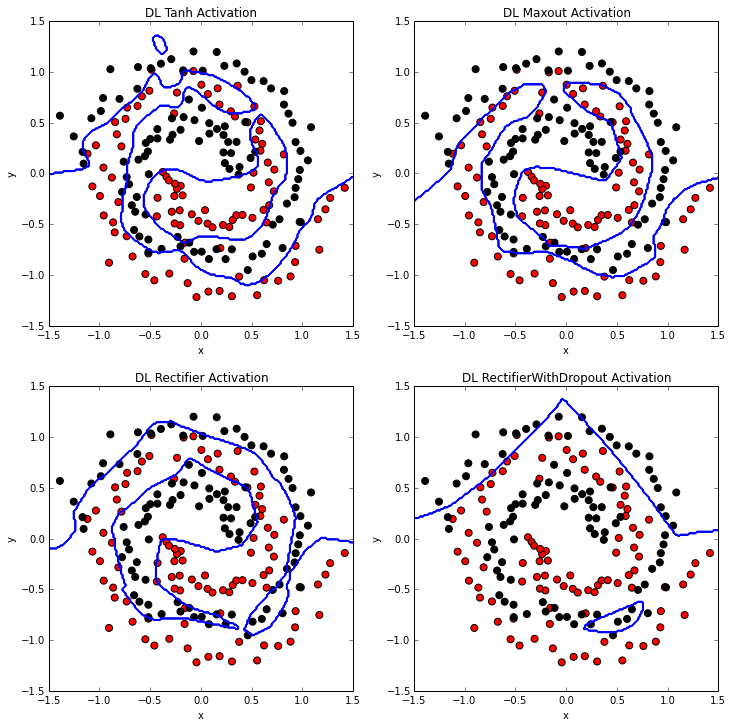

In [31]:
plot_spirals(models_act, m_names_act)

Clearly, the dropout rate was too high or the number of epochs was too low for the last configuration, which often ends up performing the best on larger datasets where generalization is important.  

More information about the parameters can be found in the [H2O Deep Learning booklet](http://h2o.ai/resources/).

## Covertype Dataset
The following examples use the Covertype dataset from UC Irvine, which concerns predicting forest cover based on cartographical data.  
We import the full covertype dataset (581k rows, 13 columns, 10 numerical, 3 categorical) and then split the data 3 ways:  
  
60% for training  
20% for validation (hyper parameter tuning)  
20% for final testing  

 We will train a data set on one set and use the others to test the validity of the model by ensuring that it can predict accurately on data the model has not been shown.  
 
 The second set will be used for validation most of the time.  
 
 The third set will be withheld until the end, to ensure that our validation accuracy is consistent with data we have never seen during the iterative process. 

In [32]:
covtype_df = h2o.import_file(path = os.path.realpath("../data/covtype.full.csv"))

#split the data as described above
train, valid, test = covtype_df.split_frame([0.6, 0.2], seed=1234)

#Prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]     #last column is cover_type, 
covtype_y = covtype_df.col_names[-1]    


Parse Progress: [##################################################] 100%


####First Impressions
Let's run our first Deep Learning model on the covtype dataset.   
We want to predict the `Cover_Type` column, a categorical feature with 7 levels, and the Deep Learning model will be tasked to perform (multi-class) classification. It uses the other 12 predictors of the dataset, of which 10 are numerical, and 2 are categorical with a total of 44 levels.  

We can expect the Deep Learning model to have 56 input neurons (after automatic one-hot encoding). First run will be only one epoch to get a feel for the model construction.

In [33]:
#set the model_id for easy lookup in Flow
covtype_model_v1 = H2ODeepLearningEstimator(model_id="covtype_v1", epochs=1, variable_importances=True)
covtype_model_v1.train(covtype_X, covtype_y, training_frame = train, validation_frame = valid)
print covtype_model_v1


deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  covtype_v1

Status of Neuron Layers: predicting Cover_Type, 7-class classification, multinomial distribution, CrossEntropy loss, 53,007 weights/biases, 633.6 KB, 383,721 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,56,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0533059,0.2161227,0.0,-0.0094923,0.1189860,0.0246888,0.1088277
,3,200,Rectifier,0.0,0.0,0.0,0.0098130,0.0075908,0.0,-0.0226829,0.1198910,0.6299940,0.4424062
,4,7,Softmax,,0.0,0.0,0.0835892,0.2416125,0.0,-0.3892993,0.4797100,-0.5508649,0.2068902




ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.13245679994
R^2: 0.933270700745
LogLoss: 0.430782042245

Confusion Matrix: vertical: actual; across: predicted



class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
2801.0,806.0,0.0,0.0,0.0,0.0,27.0,0.2292240,"833 / 3,634"
381.0,4489.0,20.0,0.0,3.0,13.0,6.0,0.0861156,"423 / 4,912"
0.0,60.0,537.0,1.0,0.0,31.0,0.0,0.1462639,92 / 629
0.0,0.0,15.0,20.0,0.0,8.0,0.0,0.5348837,23 / 43
17.0,120.0,6.0,0.0,39.0,0.0,0.0,0.7857143,143 / 182
1.0,93.0,104.0,0.0,0.0,112.0,0.0,0.6387097,198 / 310
83.0,5.0,0.0,0.0,0.0,0.0,272.0,0.2444444,88 / 360
3283.0,5573.0,682.0,21.0,42.0,164.0,305.0,0.1787488,"1,800 / 10,070"



Top-7 Hit Ratios: 


k,hit_ratio
1,0.8212512
2,0.9820258
3,0.9979145
4,0.9999006
5,0.9999999
6,0.9999999
7,0.9999999



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.135128481148
R^2: 0.930734602259
LogLoss: 0.444934350457

Confusion Matrix: vertical: actual; across: predicted



class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
32393.0,9753.0,4.0,0.0,0.0,8.0,342.0,0.2378118,"10,107 / 42,500"
4206.0,51662.0,230.0,0.0,42.0,165.0,75.0,0.0836822,"4,718 / 56,380"
0.0,843.0,5810.0,30.0,0.0,460.0,0.0,0.1866163,"1,333 / 7,143"
0.0,1.0,242.0,240.0,0.0,79.0,0.0,0.5729537,322 / 562
113.0,1352.0,58.0,0.0,345.0,2.0,0.0,0.8155080,"1,525 / 1,870"
11.0,963.0,1107.0,6.0,0.0,1377.0,0.0,0.6024827,"2,087 / 3,464"
911.0,54.0,0.0,0.0,0.0,0.0,3134.0,0.2354233,"965 / 4,099"
37634.0,64628.0,7451.0,276.0,387.0,2091.0,3551.0,0.1814977,"21,057 / 116,018"



Top-7 Hit Ratios: 


k,hit_ratio
1,0.8185023
2,0.9808995
3,0.9976211
4,0.9996035
5,0.9999828
6,1.0
7,1.0



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_MSE,training_r2,training_logloss,training_classification_error,validation_MSE,validation_r2,validation_logloss,validation_classification_error
,2016-03-04 14:29:22,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2016-03-04 14:29:28,7.276 sec,6492 rows/sec,0.0997980,1,34831.0,0.2105486,0.8939295,0.6570705,0.2789474,0.2129157,0.8908617,0.6636642,0.2809823
,2016-03-04 14:29:45,23.946 sec,8492 rows/sec,0.5012134,5,174931.0,0.1592170,0.9197894,0.5012638,0.2160874,0.1614600,0.9172374,0.5088207,0.2180696
,2016-03-04 14:30:02,41.291 sec,9560 rows/sec,0.9997622,10,348932.0,0.1372901,0.9308358,0.4331747,0.1875869,0.1403992,0.9280329,0.4454359,0.1896947
,2016-03-04 14:30:06,45.697 sec,9720 rows/sec,1.0994399,11,383721.0,0.1324568,0.9332707,0.4307820,0.1787488,0.1351285,0.9307346,0.4449344,0.1814977



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Wilderness_Area.area_0,1.0,1.0,0.0342225
Horizontal_Distance_To_Roadways,0.8542781,0.8542781,0.0292355
Wilderness_Area.area_2,0.7918279,0.7918279,0.0270983
Elevation,0.7847870,0.7847870,0.0268574
Horizontal_Distance_To_Fire_Points,0.7768059,0.7768059,0.0265842
---,---,---,---
Slope,0.3924496,0.3924496,0.0134306
Hillshade_3pm,0.3733286,0.3733286,0.0127762
Aspect,0.2777125,0.2777125,0.0095040
Soil_Type.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()



Inspect the model in [Flow](http://localhost:54321/) for more information about model building etc. 

Enter `getModel "covtype_v1"` into a cell and run in place pressing Ctrl-Enter. Alternatively, you can click on the Models tab, select List All Models, and click on the model named "covtype_v1" as specified in our model construction above.

### Variable Importances
Variable importances for Neural Network models are notoriously difficult to compute, and there are many [pitfalls](ftp://ftp.sas.com/pub/neural/importance.html). H2O Deep Learning has implemented the method of [Gedeon](http://cs.anu.edu.au/~./Tom.Gedeon/pdfs/ContribDataMinv2.pdf), and returns relative variable importances in descending order of importance.  

Note that we have exactly 56 input neurons, as expected


In [34]:
var_df = pd.DataFrame(covtype_model_v1.varimp(), 
             columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
print var_df.shape
var_df.head(10)

(56, 4)


,Variable,Relative Importance,Scaled Importance,Percentage
0,Wilderness_Area.area_0,1.000000,1.000000,0.034222
1,Horizontal_Distance_To_Roadways,0.854278,0.854278,0.029236
2,Wilderness_Area.area_2,0.791828,0.791828,0.027098
3,Elevation,0.784787,0.784787,0.026857
4,Horizontal_Distance_To_Fire_Points,0.776806,0.776806,0.026584
5,Wilderness_Area.area_3,0.704257,0.704257,0.024101
6,Wilderness_Area.area_1,0.667005,0.667005,0.022827
7,Soil_Type.type_28,0.666528,0.666528,0.022810
8,Soil_Type.type_32,0.637416,0.637416,0.021814
9,Soil_Type.type_30,0.630491,0.630491,0.021577


### Early Stopping
Now we run another, smaller network and we let it stop automatically once the misclassification rate converges (specifically if the moving average of length 2 does not improve by at least 1% for 2 consecutive scoring events).   

We also sample the validation set to 10,000 rows for faster scoring.

In [35]:
covtype_model_v2 = H2ODeepLearningEstimator(
    model_id="covtype_v2", 
    hidden=[32,32,32],                  ## small network, runs faster
    epochs=1000000,                      ## hopefully converges earlier...
    score_validation_samples=10000,      ## sample the validation dataset (faster)
    stopping_rounds=2,
    stopping_metric="misclassification", ## alternatives: "MSE","logloss","r2"
    stopping_tolerance=0.01)
covtype_model_v2.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)



deeplearning Model Build Progress: [##################################################] 100%


To look at the scoring history, we can look up our new model in Flow.  

Alternatively, we can use the score_history method to retrieve the data as a pandas DataFrame.

In [36]:
cov_v2_df = covtype_model_v2.score_history()
cov_v2_df

/Users/arno/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: DeprecationWarning: `score_history` is deprecated. Use `scoring_history`
  if __name__ == '__main__':


,,timestamp,duration,training_speed,epochs,iterations,samples,training_MSE,training_r2,training_logloss,training_classification_error,validation_MSE,validation_r2,validation_logloss,validation_classification_error
0,,2016-03-04 14:30:09,0.000 sec,None,0.000000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2016-03-04 14:30:10,1.324 sec,81807 rows/sec,0.287134,1,100214,0.199631,0.899430,0.612124,0.262165,0.205383,0.895862,0.630266,0.265565
2,,2016-03-04 14:30:16,6.763 sec,90855 rows/sec,1.723828,6,601642,0.149989,0.924438,0.478902,0.200298,0.155374,0.921219,0.494515,0.207838
3,,2016-03-04 14:30:21,12.052 sec,93014 rows/sec,3.153566,11,1100642,0.139672,0.929636,0.452457,0.190169,0.143360,0.927311,0.466675,0.193532
4,,2016-03-04 14:30:26,17.087 sec,95118 rows/sec,4.585382,16,1600367,0.132175,0.933413,0.429501,0.176167,0.138375,0.929838,0.449794,0.188696
5,,2016-03-04 14:30:32,22.918 sec,97351 rows/sec,6.307193,22,2201305,0.126808,0.936116,0.409837,0.170804,0.133102,0.932512,0.428904,0.181342
6,,2016-03-04 14:30:38,28.686 sec,98846 rows/sec,8.024890,28,2800807,0.119089,0.940005,0.392929,0.158689,0.127504,0.935350,0.418977,0.170663
7,,2016-03-04 14:30:43,34.391 sec,100071 rows/sec,9.747260,34,3401940,0.120498,0.939295,0.400791,0.159881,0.127402,0.935402,0.423552,0.171670
8,,2016-03-04 14:30:49,39.999 sec,101171 rows/sec,11.468140,40,4002553,0.118219,0.940444,0.391003,0.160874,0.126783,0.935716,0.420227,0.172577
9,,2016-03-04 14:30:54,45.538 sec,102162 rows/sec,13.189459,46,4603319,0.117743,0.940683,0.396617,0.160576,0.126481,0.935869,0.431444,0.168144


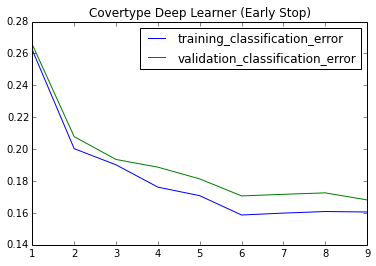

In [37]:
plt.plot(cov_v2_df['training_classification_error'], label="training_classification_error")
plt.plot(cov_v2_df['validation_classification_error'], label="validation_classification_error")
plt.title("Covertype Deep Learner (Early Stop)")
plt.legend();

### Adaptive Learning Rate
By default, H2O Deep Learning uses an adaptive learning rate ([ADADELTA](http://arxiv.org/pdf/1212.5701v1.pdf)) for its stochastic gradient descent optimization. There are only two tuning parameters for this method: `rho` and `epsilon`, which balance the global and local search efficiencies. `rho` is the similarity to prior weight updates (similar to momentum), and `epsilon` is a parameter that prevents the optimization to get stuck in local optima.  

Defaults are `rho=0.99` and `epsilon=1e-8`. For cases where convergence speed is very important, it might make sense to perform a few runs to optimize these two parameters (e.g., with `rho in c(0.9,0.95,0.99,0.999)` and `epsilon in c(1e-10,1e-8,1e-6,1e-4)`). Of course, as always with grid searches, caution has to be applied when extrapolating grid search results to a different parameter regime (e.g., for more epochs or different layer topologies or activation functions, etc.).

If `adaptive_rate` is disabled, several manual learning rate parameters become important: `rate`, `rate_annealing`, `rate_decay`, `momentum_start`, `momentum_ramp`, `momentum_stable` and `nesterov_accelerated_gradient`, the discussion of which we leave to [H2O Deep Learning booklet](http://h2o.ai/resources/).

### Tuning
With some tuning, it is possible to obtain less than 10% test set error rate in about one minute. Error rates of below 5% are possible with larger models. Deep tree methods are more effective for this dataset than Deep Learning, as the space needs to be simply be partitioned into the corresponding hyper-space corners to solve this problem.

In [38]:
covtype_model_tuned = H2ODeepLearningEstimator(
  model_id="covtype_tuned",
  overwrite_with_best_model=False,
  hidden=[128,128,128],            # more hidden layers -> more complex interactions
  epochs=10,                       # to keep it short enough
  score_validation_samples=10000,  # downsample validation set for faster scoring
  score_duty_cycle=0.025,          # don't score more than 2.5% of the wall time
  adaptive_rate=False,             # manually tuned learning rate
  rate=0.01, 
  rate_annealing=0.000002,            
  momentum_start=0.2,              # manually tuned momentum
  momentum_stable=0.4, 
  momentum_ramp=10000000, 
  l1=0.00001,                      # add some L1/L2 regularization
  l2=0.00001,
  max_w2=10                        # helps stability for Rectifier
)
covtype_model_tuned.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)


deeplearning Model Build Progress: [##################################################] 100%


Let's compare the training error with the validation and test set errors.

In [43]:
cov_tuned_df = covtype_model_tuned.scoring_history()
cov_tuned_df

,,timestamp,duration,training_speed,epochs,iterations,samples,training_MSE,training_r2,training_logloss,training_classification_error,validation_MSE,validation_r2,validation_logloss,validation_classification_error
0,,2016-03-04 14:30:55,0.000 sec,None,0.000000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2016-03-04 14:31:00,5.551 sec,18936 rows/sec,0.287134,1,100214,0.181741,0.908442,0.557212,0.238828,0.182738,0.907344,0.556259,0.243703
2,,2016-03-04 14:31:13,17.935 sec,22948 rows/sec,1.149721,4,401270,0.126748,0.936147,0.399298,0.170705,0.134900,0.931600,0.426963,0.185976
3,,2016-03-04 14:31:20,25.541 sec,24152 rows/sec,1.723828,6,601642,0.107544,0.945821,0.341149,0.143793,0.114347,0.942022,0.364321,0.155450
4,,2016-03-04 14:31:28,32.976 sec,24902 rows/sec,2.294916,8,800960,0.098170,0.950544,0.314457,0.131182,0.105392,0.946562,0.337559,0.141648
5,,2016-03-04 14:31:35,40.307 sec,25445 rows/sec,2.866123,10,1000320,0.091198,0.954056,0.293201,0.120953,0.100449,0.949068,0.326792,0.132984
6,,2016-03-04 14:31:42,47.626 sec,25843 rows/sec,3.439609,12,1200475,0.083934,0.957715,0.271348,0.114697,0.093775,0.952452,0.305643,0.127040
7,,2016-03-04 14:31:50,54.909 sec,26148 rows/sec,4.012727,14,1400502,0.076110,0.961657,0.248049,0.102781,0.086216,0.956285,0.281106,0.117268
8,,2016-03-04 14:31:57,1 min 2.145 sec,26402 rows/sec,4.585382,16,1600367,0.075266,0.962083,0.242202,0.103078,0.084276,0.957269,0.276799,0.113036
9,,2016-03-04 14:32:07,1 min 12.844 sec,26720 rows/sec,5.445826,19,1900675,0.070796,0.964334,0.230593,0.093446,0.081318,0.958768,0.265202,0.110719


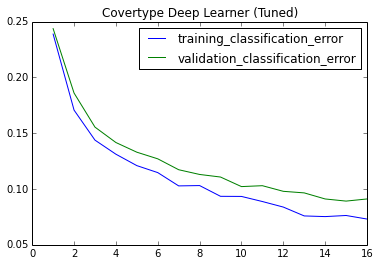

In [40]:
plt.plot(cov_tuned_df['training_classification_error'], label="training_classification_error")
plt.plot(cov_tuned_df['validation_classification_error'], label="validation_classification_error")
plt.title("Covertype Deep Learner (Tuned)")
plt.legend();

In [41]:
pred = covtype_model_tuned.predict(test[0:-1]).as_data_frame(use_pandas=True)
test_actual = test.as_data_frame(use_pandas=True)['Cover_Type']
(test_actual == pred['predict']).mean()


deeplearning prediction Progress: [##################################################] 100%


0.91908017830814204

As you can see, we've achieved approximately 90% accuracy on our test data, which is fairly in line with our validation results.

###Shutdown H2O Cluster
This concludes the Python portion of the deeplearning demo.  

Shut down the cluster now that we are done using it.

In [42]:
h2o.shutdown(prompt=False)

##Unsupervised Anomaly detection
For instructions on how to build unsupervised models with H2O Deep Learning, we refer to our previous [Tutorial on Anomaly Detection with H2O Deep Learning](https://www.youtube.com/watch?v=fUSbljByXak) and our [MNIST Anomaly detection code example](https://github.com/h2oai/h2o-3/blob/master/h2o-r/tests/testdir_algos/deeplearning/runit_deeplearning_anomaly_large.R), as well as our [Stacked AutoEncoder R code example](https://github.com/h2oai/h2o-3/blob/master/h2o-r/tests/testdir_algos/deeplearning/runit_deeplearning_stacked_autoencoder_large.R).


##H2O Deep Learning Tips & Tricks
####Activation Functions
While sigmoids have been used historically for neural networks, H2O Deep Learning implements `Tanh`, a scaled and shifted variant of the sigmoid which is symmetric around 0. Since its output values are bounded by -1..1, the stability of the neural network is rarely endangered. However, the derivative of the tanh function is always non-zero and back-propagation (training) of the weights is more computationally expensive than for rectified linear units, or `Rectifier`, which is `max(0,x)` and has vanishing gradient for `x<=0`, leading to much faster training speed for large networks and is often the fastest path to accuracy on larger problems. In case you encounter instabilities with the `Rectifier` (in which case model building is automatically aborted), try a limited value to re-scale the weights: `max_w2=10`. The `Maxout` activation function is computationally more expensive, but can lead to higher accuracy. It is a generalized version of the Rectifier with two non-zero channels. In practice, the `Rectifier` (and `RectifierWithDropout`, see below) is the most versatile and performant option for most problems.

####Generalization Techniques
L1 and L2 penalties can be applied by specifying the `l1` and `l2` parameters. Intuition: L1 lets only strong weights survive (constant pulling force towards zero), while L2 prevents any single weight from getting too big. [Dropout](http://arxiv.org/pdf/1207.0580.pdf) has recently been introduced as a powerful generalization technique, and is available as a parameter per layer, including the input layer. `input_dropout_ratio` controls the amount of input layer neurons that are randomly dropped (set to zero), while `hidden_dropout_ratios` are specified for each hidden layer. The former controls overfitting with respect to the input data (useful for high-dimensional noisy data), while the latter controls overfitting of the learned features. Note that `hidden_dropout_ratios` require the activation function to end with `...WithDropout`.

####Early stopping and optimizing for lowest validation error
By default, Deep Learning training stops when the `stopping_metric` does not improve by at least `stopping_tolerance` (0.01 means 1% improvement) for `stopping_rounds` consecutive scoring events on the training (or validation) data. By default, `overwrite_with_best_model` is enabled and the model returned after training for the specified number of epochs (or after stopping early due to convergence) is the model that has the best training set error (according to the metric specified by `stopping_metric`), or, if a validation set is provided, the lowest validation set error. Note that the training or validation set errors can be based on a subset of the training or validation data, depending on the values for `score_validation_samples` or `score_training_samples`, see below. For early stopping on a predefined error rate on the *training data* (accuracy for classification or MSE for regression), specify `classification_stop` or `regression_stop`.

####Training Samples per MapReduce Iteration
The parameter `train_samples_per_iteration` matters especially in multi-node operation. It controls the number of rows trained on for each MapReduce iteration. Depending on the value selected, one MapReduce pass can sample observations, and multiple such passes are needed to train for one epoch. All H2O compute nodes then communicate to agree on the best model coefficients (weights/biases) so far, and the model may then be scored (controlled by other parameters below). The default value of `-2` indicates auto-tuning, which attemps to keep the communication overhead at 5% of the total runtime. The parameter `target_ratio_comm_to_comp` controls this ratio. This parameter is explained in more detail in the [H2O Deep Learning booklet](http://h2o.ai/resources/),

####Categorical Data
For categorical data, a feature with K factor levels is automatically one-hot encoded (horizontalized) into K-1 input neurons. Hence, the input neuron layer can grow substantially for datasets with high factor counts. In these cases, it might make sense to reduce the number of hidden neurons in the first hidden layer, such that large numbers of factor levels can be handled. In the limit of 1 neuron in the first hidden layer, the resulting model is similar to logistic regression with stochastic gradient descent, except that for classification problems, there's still a softmax output layer, and that the activation function is not necessarily a sigmoid (`Tanh`). If variable importances are computed, it is recommended to turn on `use_all_factor_levels` (K input neurons for K levels). The experimental option `max_categorical_features` uses feature hashing to reduce the number of input neurons via the hash trick at the expense of hash collisions and reduced accuracy. Another way to reduce the dimensionality of the (categorical) features is to use `h2o.glrm()`, we refer to the GLRM tutorial for more details.

####Missing Values
H2O Deep Learning automatically does mean imputation for missing values during training (leaving the input layer activation at 0 after standardizing the values). For testing, missing test set values are also treated the same way by default. See the `h2o.impute` function to do your own mean imputation.

####Loss functions, Distributions, Offsets, Observation Weights
H2O Deep Learning supports advanced statistical features such as multiple loss functions, non-Gaussian distributions, per-row offsets and observation weights.
In addition to `Gaussian` distributions and `Squared` loss, H2O Deep Learning supports `Poisson`, `Gamma`, `Tweedie` and `Laplace` distributions. It also supports `Absolute` and `Huber` loss and per-row offsets specified via an `offset_column`. Observation weights are supported via a user-specified `weights_column`.

We refer to our [H2O Deep Learning R test code examples](https://github.com/h2oai/h2o-3/tree/master/h2o-r/tests/testdir_algos/deeplearning) for more information.
a

####Reproducibility
Every run of DeepLearning results in different results since multithreading is done via [Hogwild!](http://www.eecs.berkeley.edu/~brecht/papers/hogwildTR.pdf) that benefits from intentional lock-free race conditions between threads. To get reproducible results for small datasets and testing purposes, set `reproducible=T` and set `seed=1337` (pick any integer). This will not work for big data for technical reasons, and is probably also not desired because of the significant slowdown (runs on 1 core only).
    
####Scoring on Training/Validation Sets During Training  
The training and/or validation set errors *can* be based on a subset of the training or validation data, depending on the values for `score_validation_samples` (defaults to 0: all) or `score_training_samples` (defaults to 10,000 rows, since the training error is only used for early stopping and monitoring). For large datasets, Deep Learning can automatically sample the validation set to avoid spending too much time in scoring during training, especially since scoring results are not currently displayed in the model returned to R.
                                
Note that the default value of `score_duty_cycle=0.1` limits the amount of time spent in scoring to 10%, so a large number of scoring samples won't slow down overall training progress too much, but it will always score once after the first MapReduce iteration, and once at the end of training.

Stratified sampling of the validation dataset can help with scoring on datasets with class imbalance.  Note that this option also requires `balance_classes` to be enabled (used to over/under-sample the training dataset, based on the max. relative size of the resulting training dataset, `max_after_balance_size`):
    
### More information can be found in the [H2O Deep Learning booklet](http://h2o.ai/resources/), in our [H2O SlideShare Presentations](http://www.slideshare.net/0xdata/presentations), our [H2O YouTube channel](https://www.youtube.com/user/0xdata/), as well as on our [H2O Github Repository](https://github.com/h2oai/h2o-3/), especially in our [H2O Deep Learning R tests](https://github.com/h2oai/h2o-3/tree/master/h2o-r/tests/testdir_algos/deeplearning), and [H2O Deep Learning Python tests](https://github.com/h2oai/h2o-3/tree/master/h2o-py/tests/testdir_algos/deeplearning).

###Further Exploration
Due to the limited scope of this talk, only a portion of the code has been ported to Python.  

Additional topics are covered in R: Please see the deeplearning.R file for code samples for the following:

* Hyper-Parameter tuning with Grid Search  
* Random Hyper-Parameter Search  
* Checkpointing  
* Cross-Validation  
* Regression and Binary Classification  
* Exporting Weights and Biases
